In [1]:
import re
import os
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
from contractions import contractions_dict

In [2]:
def expand_contractions(text, contraction_map=None):
    if contraction_map is None:
        contraction_map = contractions_dict

    # Using regex for getting all contracted words
    contractions_keys = '|'.join(re.escape(key) for key in contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    expanded_text = contractions_pattern.sub(lambda match: contraction_map.get(match.group(0), match.group(0)), text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [3]:
# Function to detect file encoding
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

In [4]:
# Set the base directory
base_dir = "data/BBCNewsSummary/News Articles"
output_dir = "data/BBCNewsSummaryCSV"  # Output directory

# Check if the output directory exists, and create it if not
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get the list of classes (subfolder names)
classes = os.listdir(base_dir)
dfs = {}
# Create dataframes and write to CSV files for each class
for class_name in classes:
    # Define the paths for news articles and summaries
    news_articles_path = os.path.join(base_dir, class_name)
    summaries_path = os.path.join("data/BBCNewsSummary/Summaries", class_name)

    # Get the list of file names in both directories
    news_articles_files = os.listdir(news_articles_path)
    summaries_files = os.listdir(summaries_path)

    # Match file names
    common_files = set(news_articles_files) & set(summaries_files)

    # Create dataframe
    df_list = []

    # Read content from files and populate dataframe
    for filename in sorted(common_files):  # Sort by filename
        news_article_file_path = os.path.join(news_articles_path, filename)
        summary_file_path = os.path.join(summaries_path, filename)

        # Detect encoding
        news_encoding = detect_encoding(news_article_file_path)
        summary_encoding = detect_encoding(summary_file_path)

        try:
            with open(news_article_file_path, 'r', encoding=news_encoding) as news_file, \
                    open(summary_file_path, 'r', encoding=summary_encoding) as summary_file:
                news_content = news_file.read()
                summary_content = summary_file.read()
                

                # Extract file name without extension
                file_name_without_extension = os.path.splitext(filename)[0]

                # Generate the new entry in the filename
                new_filename = f'{class_name}_{file_name_without_extension}'

                df_list.append({'filename': new_filename, 'newsarticle': news_content, 'summary': summary_content})

        except UnicodeDecodeError:
            print(f"UnicodeDecodeError: Could not read {filename}. Skipping this file.")

    # Create dataframe from the list and sort by filename
    df = pd.DataFrame(df_list).sort_values(by='filename')
    
    # Save dataframe to the dictionary
    dfs[class_name] = df


    # # Write dataframe to CSV in the output directory
    # csv_filename = os.path.join(output_dir, f'{class_name}_data.csv')
    # df.to_csv(csv_filename, index=False)
    # print(f'Dataframe for {class_name} written to {csv_filename}')


In [5]:
business = dfs['business']
entertainment = dfs['entertainment']
sport = dfs['sport']
politics = dfs['politics']
tech = dfs['tech']

In [6]:
sample_text = business['newsarticle'][242] 

In [7]:
sample_text

"Making your office work for you\n\nOur mission to brighten up your working lives continues - and this time, we're taking a long hard look at your offices.\n\nOver the next few months, our panel of experts will be listening to your gripes about where you work, and suggesting ways to make your workspace more efficient, more congenial or simply prettier. This week, we're hearing from Marianne Petersen, who is planning to convert a barn in Sweden into a base for her freelance writing work. Click on the link under her photograph to read her story, and then scroll down to see what the panel have to say. And if you want to take part in the series, go to the bottom of the story to find out how to get in touch.\n\nWorking from home presents a multitude of challenges. Understanding your work personality allows you to work in terms of your own style. Do you feel confident about your work output without conferring with others? Are you able to retain discipline and self motivate to get the job don

In [8]:
training_dataset = pd.concat([business,politics,tech], ignore_index=True)
testing_dataset = pd.concat([entertainment,sport], ignore_index=True)

In [9]:
print("Training size:",training_dataset.size)
print("Testing size:",testing_dataset.size)

Training size: 3984
Testing size: 2691


In [10]:
training_dataset = training_dataset.sample(frac=1).reset_index(drop=True)
testing_dataset = testing_dataset.sample(frac=1).reset_index(drop=True)

In [11]:
training_dataset['newsarticle'] = training_dataset['newsarticle'].apply(expand_contractions)
testing_dataset['newsarticle'] = testing_dataset['newsarticle'].apply(expand_contractions)

In [12]:
def getSenLen(sentence):
    return len(sentence.split())

In [13]:
training_dataset['article_length'] = training_dataset['newsarticle'].apply(getSenLen)
training_dataset['summary_length'] = training_dataset['summary'].apply(getSenLen)
testing_dataset['article_length'] = testing_dataset['newsarticle'].apply(getSenLen)
testing_dataset['summary_length'] = testing_dataset['summary'].apply(getSenLen)


In [14]:
training_dataset.head()

,filename,newsarticle,summary,article_length,summary_length
0,business_080,"Argentina, Venezuela in oil deal\n\nArgentina ...",Argentine President Nestor Kirchner and Venezu...,191,84
1,tech_232,BBC web search aids odd queries\n\nThe BBCs on...,Search engines are key to the way people use t...,230,108
2,tech_044,Apple attacked over sources row\n\nCivil liber...,"The EFF, representing the reporters, has asked...",321,150
3,politics_187,Jowell confirms casino climbdown\n\nTessa Jowe...,"""Limiting the number of regional casinos to ei...",390,172
4,tech_024,Game firm holds cast auditions\n\nVideo game f...,People chosen to appear in a game will have th...,289,97


Text(0.5, 1.0, 'Boxplot of Summary Lengths')

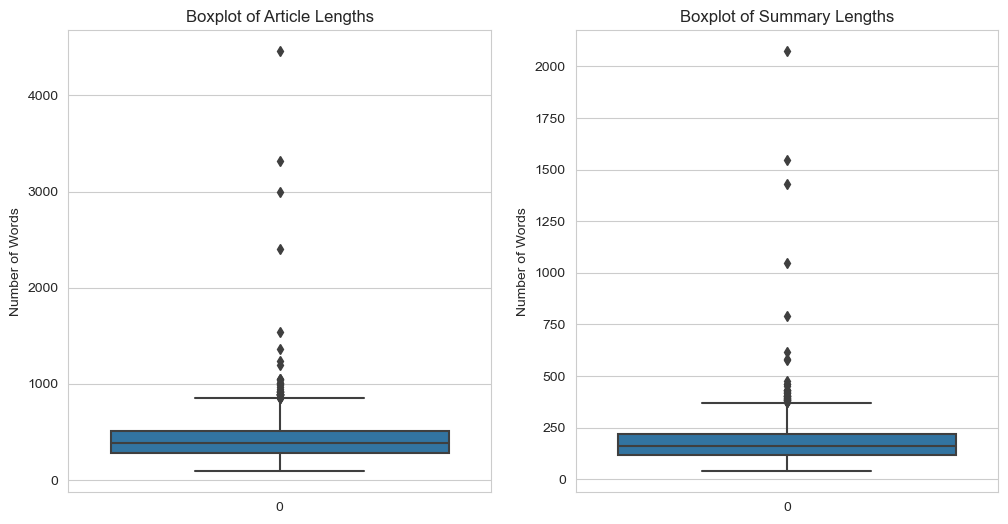

In [15]:
# Boxplots for Article and Summary Lengths
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(training_dataset["article_length"], ax=axes[0])
axes[0].set_ylabel("Number of Words")
axes[0].set_title("Boxplot of Article Lengths")

sns.boxplot(training_dataset["summary_length"], ax=axes[1])
axes[1].set_ylabel("Number of Words")
axes[1].set_title("Boxplot of Summary Lengths")

In [16]:
training_dataset.describe()

,article_length,summary_length
count,1328.000000,1328.000000
mean,421.438253,179.762048
std,242.685544,110.777280
min,90.000000,38.000000
25%,280.750000,118.000000
50%,380.000000,161.000000
75%,508.250000,219.000000
max,4460.000000,2073.000000


In [17]:
# Get statistics for the articles boxplot
lines_articles = axes[0].lines[:6]
articles_stats = [line.get_ydata()[0] for line in lines_articles]
Q1_articles, Q3_articles, lower_whisker_articles, upper_whisker_articles, median_articles = articles_stats[:5]

# Get statistics for the summaries boxplot
lines_summaries = axes[1].lines[:6]
summaries_stats = [line.get_ydata()[0] for line in lines_summaries]
Q1_summaries, Q3_summaries, lower_whisker_summaries, upper_whisker_summaries, median_summaries = summaries_stats[:5]

In [18]:
print(upper_whisker_articles)
print(upper_whisker_summaries)

849.0
369.0


In [19]:
training_dataset = training_dataset[(training_dataset['summary_length'] <= upper_whisker_summaries) & (training_dataset['article_length'] <= upper_whisker_articles)]
testing_dataset = testing_dataset[(testing_dataset['summary_length'] <= upper_whisker_summaries) & (testing_dataset['article_length'] <= upper_whisker_articles)]

Text(0.5, 1.0, 'Boxplot of Summary Lengths')

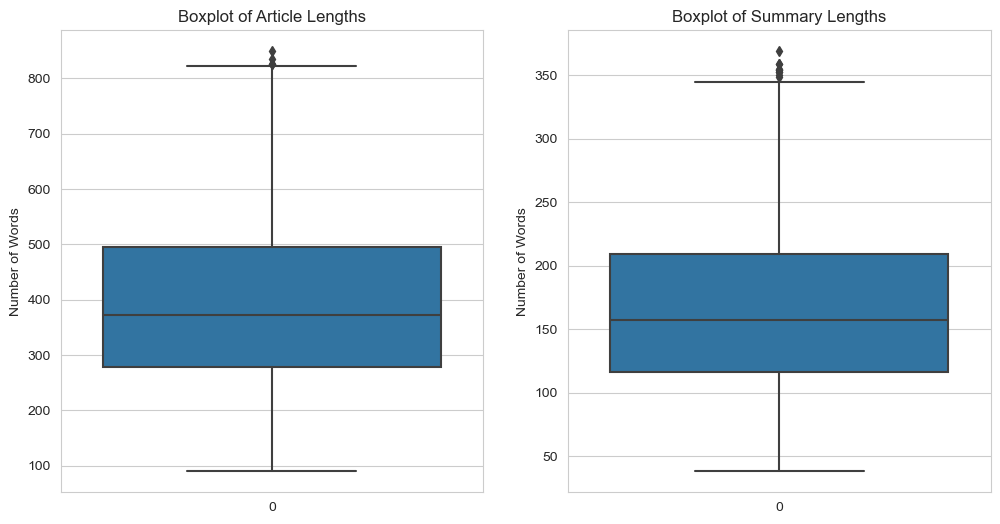

In [20]:
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for the articles' number of words
sns.boxplot(training_dataset["article_length"], ax=axes[0])
axes[0].set_ylabel("Number of Words")
axes[0].set_title("Boxplot of Article Lengths")

# Plot for the summaries' number of words
sns.boxplot(training_dataset["summary_length"], ax=axes[1])
axes[1].set_ylabel("Number of Words")
axes[1].set_title("Boxplot of Summary Lengths")


In [21]:
training_dataset.head()

,filename,newsarticle,summary,article_length,summary_length
0,business_080,"Argentina, Venezuela in oil deal\n\nArgentina ...",Argentine President Nestor Kirchner and Venezu...,191,84
1,tech_232,BBC web search aids odd queries\n\nThe BBCs on...,Search engines are key to the way people use t...,230,108
2,tech_044,Apple attacked over sources row\n\nCivil liber...,"The EFF, representing the reporters, has asked...",321,150
3,politics_187,Jowell confirms casino climbdown\n\nTessa Jowe...,"""Limiting the number of regional casinos to ei...",390,172
4,tech_024,Game firm holds cast auditions\n\nVideo game f...,People chosen to appear in a game will have th...,289,97


In [22]:
training_dataset.describe()

,article_length,summary_length
count,1281.000000,1281.000000
mean,394.962529,167.705699
std,151.600885,66.488051
min,90.000000,38.000000
25%,278.000000,116.000000
50%,372.000000,157.000000
75%,496.000000,209.000000
max,849.000000,369.000000


In [23]:
df = training_dataset[0:100]
# df = training_dataset

In [35]:
from transformers import pipeline
from sklearn.model_selection import train_test_split
summarizer = pipeline('summarization', model = 'facebook/bart-base')
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
test_df = testing_dataset[0:len(val_df)]
len(test_df)

20

In [36]:
import pandas as pd
from rouge_score import rouge_scorer
from bert_score import score as bert_score


# Function to apply summarizer and calculate scores for each row
def tr_summarize(row):
    global c
    c+=1
    print(c)
    news_article = row['newsarticle']
    actual_summary = row['summary']

    # Generate extractive summary
    # extr = summarizer(news_article)
    # extractive_summary_str = summarizer(news_article)[0]['summary_text']
    extractive_summary_str = summarizer(news_article, max_length=280, min_length=50, length_penalty=2.0, num_beams=4)[0]['summary_text']
    print(extractive_summary_str)
    
    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
    rouge_scores = scorer.score(extractive_summary_str, actual_summary)
    # rouge_scores = scorer.score(' '.join(item['text'] for item in extractive_summary_str), actual_summary)



    # Compute BERT scores
    _, _, bert_f1 = bert_score([extractive_summary_str], [actual_summary], lang='en', model_type='bert-base-uncased')

    return pd.Series({
        'predicted_summary': extractive_summary_str,
        'rouge1_precision': rouge_scores['rouge1'].precision,
        'bert_score': bert_f1.item()
    })

c = 0
# Apply the process_row function to each row in the DataFrame
result_df = test_df.apply(tr_summarize, axis=1)

# Concatenate the result_df with the original DataFrame
base_result_dataset = pd.concat([test_df, result_df], axis=1)

# Print the updated DataFrame
# print(testing_dataset)



1
Moya clinches Cup for SpainSpain won the Davis Cup for the second time in their history when Carlos Moya beat the USAs Andy Roddick in the fourth rubber in Seville. (Photo: AFP/Getty Images)Moya won 6-2 7-6 (7-1) 7-1 lead with only one singles rubber remaining. Spain beat the United States 6-3 6-4 6-1 in the final dead rubber to cut Spains' winning margin to 3-2. Spain won their second Davis Cup title in four years when they beat France in Paris in 2000. Moya dominated the first set to give the Spaniards an unassailable 3-0 lead with the hosts an undistinguished 4-2 tie-break victory in the second match. Roddrick battled hard and had chances in the two tie-breaks to win the second set, but Moyas clay-court expertise proved the difference. Mardy Fish beat Tommy Robredo 7- 6 (8-6) 6-0 in the third dead rubber of the final, cutting Spains winning margin by three points. Spains only other Davis Cup final came in 2000, whenThey beat Australia in Barcelona. This time they chose to play the

Your max_length is set to 280, but your input_length is only 229. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=114)


3
EastEnders is set for US remake with a US cast - reportPlans to create a US soap based on the BBCs EastEnders have reportedly been drawn up by the Fox TV network. The series is set to air in the US in the autumn of 2018.BBC East Enders EastEnder EastEndERS head writer Tony Jordan and music mogul Simon Fuller are involved in the project, according to reports in the Hollywood Reporter trade newspaper. It said scripts have been commissioned for a series about a community of working class people living in the suburbs of Chicago. The original WestEnders was pulled from BBC America last year after it proved a failure in the ratings. US versions of other British hits have proved less successful across the Atlantic.BBC Coupling BBC CouplingBBC comedy Coupling was remade with a UK cast, but lost its primetime slot on the NBC network due to disappointing ratings. At home, EastEnds has been facing its own ratings battle, recently losing out to rival ITV soap Emmer dale. Primetime soaps on US te

Your max_length is set to 280, but your input_length is only 266. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=133)


8
Hendrix guitar fetches £100,000 at London auctionA much-loved guitar belonging to Jimi Hendrix has been sold for £100k at an auction in London. The Fender Stratocaster was one of a number of guitars included in the sale dedicated to the rock legend. The vast archive of instruments, signed records and posters were collected by a dedicated fan who had become friendly with the star. The auction was billed as the biggest collection of Hendrix memorabilia to go under the hammer. The majority of the items were collect by fan Bob Terry who began collecting at the age of 17. He later sold it on to another collector. The guitar was used by Hendrix on tour and in his studio during the 1970s and 1980s. It was also used by the musician on his first solo album Hey Joe, signed by all the band members.The guitar was owned by the legendary rocker in 1970 at the time of his death from a drug overdose.The guitars were owned by all of the rockers. The 1963 Fender Strocaster had been used for the musici

Your max_length is set to 280, but your input_length is only 243. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=121)


11
Hamm bows out for US Women's World Cup finalWomens football legend Mia Hamm has played her final game. She will retire from international football at the end of the 2018 World Cup.Hamm, 32, who officially retired after this years Athens Olympics, took to the field for the last time to help the US claim a 5-0 win over Mexico. Hamm ends her career as the most prolific scorer - male or female - in international football, with 158 goals in 276 games for the US. She was twice Fifa womens player of the year and won the World Cup in 1991 and 1999 and two Olympic golds. On her retirement, Hamm said: "There are mixed emotions. There are things in your life that you have had to put on the back-burner and you can focus more time and energy on that now. "I have to see what is out there and not commit to everything at the beginning." The friendly also saw the beginning of Julie Foudy and Joy Fawcett's US careers. Hamm will now embark on a new life with husband, Chicago Cubs shortstop Nomar Garci

Your max_length is set to 280, but your input_length is only 267. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=133)


13
Russian film wins BBC world prize for 'The Return'Russian drama The Return (Vozvrashchenie) has been named winner of the BBC Four World Cinema Award. The film has been nominated for the prestigious award for "The Return".The film tells the story of two adolescent boys who are subjected to a harsh regime when their strict father returns after a 10-year absence. Directed by Andrey Zvyagintsev, The Return previously won the 2003 Golden Lion award at the Venice Film Festival. The prize was presented at an awards ceremony held in London on Thursday and hosted by Jonathan Ross. The winner was chosen by a panel which included X Files actress Gillian Anderson, critic Roger Clarke and Touching the Void director Kevin McDonald. It was the first time the award has been given to a Russian film.Ross, who is the presenter of BBC Ones Film 2005, was also involved in the deliberations. A shortlist of six films from around the world had been drawn up from which the panel chose. Other nominees includ

Your max_length is set to 280, but your input_length is only 246. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=123)


14
Housewives lift Channel 4 ratings in JanuaryThe debut of US television hit Desperate Housewives has helped lift Channel fours January audience share by 12% compared to last year. Its share of the audience rose from 11.2% to 12.6% in January.Other successes such as Celebrity Big Brother and The Simpsons have enabled the broadcaster to surpass BBC Two for the first month since last July. BBC Twofs show's share of The Simpsons fell from 10% to 9.1% last month in comparison with January 2004. Celebrity Big brother attracted fewer viewers than its 2002 series.Channel 4 has also seen a rise in the number of viewers it has seen over the past year, with the BBC reporting a rise of one million viewers in January compared with January 2005.Comedy drama Desperate housewives managed to pull in five million viewers at one point during its run to date, attracting a quarter of the television audience. The two main television channels, BBC1 and ITV1, have both seen their monthly audience share decl

In [37]:
base_result_dataset['rouge1_precision'].mean()

0.7618620107956544

In [38]:
base_result_dataset['bert_score'].mean()

0.7290657520294189

In [24]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from rouge_score import rouge_scorer
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_
from bert_score import score as bert_score

In [25]:
# Define the device for GPU usage (if available)
if torch.backends.mps.is_available():
    arch = "mps"
elif torch.cuda.is_available():
    arch = "cuda"
else:
    arch = "cpu"

# device = torch.device(arch)
device = torch.device("cpu")

In [26]:
# Tokenize and preprocess the text data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
max_length = 512  # Maximum sequence length

def tokenize_text(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized inputs to the GPU

def tokenize_summary(text):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=280, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized summaries to the GPU

def tokenize_and_stack(df, text_column, summary_column):
    df['TokenizedText'] = df[text_column].apply(tokenize_text)
    df['TokenizedSummary'] = df[summary_column].apply(tokenize_summary)
    
    # Convert tokenized data to PyTorch tensors
    X = torch.stack([seq.squeeze() for seq in df['TokenizedText']])
    Y = torch.stack([seq.squeeze() for seq in df['TokenizedSummary']])
    
    # Define a DataLoader for batching data
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    return X, Y, dataloader

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
test_df = testing_dataset[0:len(val_df)]

# Tokenize and stack for training set
X_train, Y_train, train_dataloader = tokenize_and_stack(train_df, 'newsarticle', 'summary')

# Tokenize and stack for validation set
X_val, Y_val, val_dataloader = tokenize_and_stack(val_df, 'newsarticle', 'summary')

# Tokenize and stack for validation set
X_test, Y_test, test_dataloader = tokenize_and_stack(test_df, 'newsarticle', 'summary')



/var/folders/qd/t1dpxdpn0xj2byx5h2wvvzr80000gn/T/ipykernel_70826/827037185.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TokenizedText'] = df[text_column].apply(tokenize_text)
/var/folders/qd/t1dpxdpn0xj2byx5h2wvvzr80000gn/T/ipykernel_70826/827037185.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TokenizedSummary'] = df[summary_column].apply(tokenize_summary)


In [27]:
def genSummaryAndEvaluate(model, dataloader):
    model.eval()
    
    test_articles = []
    actual_summaries = []
    predicted_summaries = []
    rouge1_precision_scores = []
    bert_scores = []
    embedding_cosine_similarity = []

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Test"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            max_length=280
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=280, num_beams=17, length_penalty=2.0, early_stopping=False)
            
            for output, target, input_text in zip(outputs, targets, inputs):
                # Calculate ROUGE-1 precision for each sample
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                target_text = ' '.join(target_text.split()[:max_length])
                rouge_scores = scorer.score(output_text, target_text)
                rouge1_precision_scores.append(rouge_scores['rouge1'].precision)
                                                
                # # BERTScore
                _, _, bert_score_f1 = bert_score([output_text], [target_text], lang='en', model_type='bert-base-uncased')
                bert_scores.append(bert_score_f1.item())
                
                # Append tokenized text, actual summaries, and predicted summaries
                test_articles.append(tokenizer.decode(input_text, skip_special_tokens=True))
                actual_summaries.append(target_text)
                predicted_summaries.append(output_text)

    data = {
        'Article': test_articles,
        'Actual Summary': actual_summaries,
        'Predicted Summary': predicted_summaries,
        'ROUGE-1 Precision': rouge1_precision_scores,
        'BERT Score': bert_scores,

    }
    results_df = pd.DataFrame(data)
    return results_df
    # return test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores


In [28]:
# Define the BART model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

# Create a GradScaler for mixed-precision training
scaler = GradScaler()

# Define hyperparameters
model.to(device)  # Move the model to the GPU
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=len(
    train_dataloader) * 10)  # Add learning rate scheduler

# Define gradient accumulation steps
accumulation_steps = 40  # You can adjust this number

# Training loop
train_losses = []
rouge_scores = []
bert_scores = []
for epoch in range(3):  # Change the number of epochs as needed
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{2}")):
        inputs = batch[0].to(device)  # Move the input batch to the GPU
        attention_mask = (inputs != 0).float().to(device)  # Create attention mask
        targets = batch[1].to(device)  # Move the target batch to the GPU

        with autocast():
            outputs = model(input_ids=inputs, attention_mask=attention_mask, decoder_input_ids=targets, labels=targets)
            loss = outputs.loss

        # Perform gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            # Update gradients and optimizer once every accumulation_steps
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    train_loss = total_loss / len(train_dataloader)
    train_losses.append(train_loss)
    evalResult = genSummaryAndEvaluate(model, val_dataloader)
    rouge = evalResult['ROUGE-1 Precision']
    bert = evalResult['BERT Score']
    rouge_scores.append(rouge.mean())
    bert_scores.append(bert.mean())
    print(
        f"Epoch {epoch + 1}/{2}, Train Loss: {train_loss:.4f}, Mean Evaluation Rouge-1 Score: {rouge.mean()}, Mean Evaluation BERT Score: {bert.mean()}")

sameCategoryData = evalResult

# Save the model after training
# model.save_pretrained("KYS_BART_BASE")
model.save_pretrained("Test")

/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:124: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/2:   0%|          | 0/20 [00:00<?, ?it/s]/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Evaluating Test: 100%|██████████| 5/5 [27:10<00:00, 326.20s/it]


Epoch 1/2, Train Loss: 0.2554, Mean Evaluation Rouge-1 Score: 0.49927780763214136, Mean Evaluation BERT Score: 0.6604024589061737


Evaluating Test:  40%|████      | 2/5 [19:11<28:47, 575.77s/it]


KeyboardInterrupt: 

In [ ]:
train_losses

In [ ]:
rouge_scores

In [ ]:
bert_scores

In [ ]:
# Plot the Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)

# train_losses = [0.30070960372686384, 0.30086159333586693, 0.30086159333586693, 0.30086159333586693]
# 
# rouge_scores = [0.8, 0.85, 0.88, 0.92]  # Replace with your actual ROUGE scores
# bert_scores = [0.75, 0.78, 0.82, 0.86]   # Replace with your actual BERT scores
epochs = list(range(1, len(train_losses) + 1))
# Create subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot train losses on the first y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='tab:blue')
ax1.plot(epochs, train_losses, color='tab:blue', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis for ROUGE and BERT scores
ax2 = ax1.twinx()
ax2.set_ylabel('ROUGE / BERT Scores', color='tab:red')

# Plot ROUGE scores on the second y-axis
ax2.plot(epochs, rouge_scores, color='tab:red', linestyle='dashed', label='ROUGE Scores')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Plot BERT scores on the second y-axis
ax2.plot(epochs, bert_scores, color='tab:orange', linestyle='dashed', label='BERT Scores')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add legend
ax2.legend(loc='upper right')

# Show the plot
plt.title('Learning Curves')
plt.show()


sameCategoryData = genSummaryAndEvaluate(model,val_dataloader)

In [ ]:
sameCategoryData[['ROUGE-1 Precision','BERT Score']]

In [ ]:
print(sameCategoryData['ROUGE-1 Precision'].mean(),sameCategoryData['BERT Score'].mean())

In [ ]:
diffCategoryData = genSummaryAndEvaluate(model,test_dataloader)

In [ ]:
diffCategoryData[['ROUGE-1 Precision','BERT Score']]

In [ ]:
print(diffCategoryData['ROUGE-1 Precision'].mean(),diffCategoryData['BERT Score'].mean())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
same_category_mean_rouge1 = sameCategoryData['ROUGE-1 Precision'].mean()
same_category_mean_bert = sameCategoryData['BERT Score'].mean()

diff_category_mean_rouge1 = diffCategoryData['ROUGE-1 Precision'].mean()
diff_category_mean_bert = diffCategoryData['BERT Score'].mean()

categories = ['ROUGE-1 Precision', 'BERT Score']
mean_scores_same_category = [same_category_mean_rouge1, same_category_mean_bert]
mean_scores_diff_category = [diff_category_mean_rouge1, diff_category_mean_bert]

bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots()
bar1 = ax.bar(index, mean_scores_same_category, bar_width, label='Same Category')
bar2 = ax.bar(index + bar_width, mean_scores_diff_category, bar_width, label='Different Category')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Score')
ax.set_title('Mean ROUGE-1 Precision and BERT Score Comparison between Categories')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
same_category_median_rouge1 = sameCategoryData['ROUGE-1 Precision'].median()
same_category_median_bert = sameCategoryData['BERT Score'].median()

diff_category_median_rouge1 = diffCategoryData['ROUGE-1 Precision'].median()
diff_category_median_bert = diffCategoryData['BERT Score'].median()

categories = ['ROUGE-1 Precision', 'BERT Score']
median_scores_same_category = [same_category_median_rouge1, same_category_median_bert]
median_scores_diff_category = [diff_category_median_rouge1, diff_category_median_bert]

bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots()
bar1 = ax.bar(index, median_scores_same_category, bar_width, label='Same Category')
bar2 = ax.bar(index + bar_width, median_scores_diff_category, bar_width, label='Different Category')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('median Score')
ax.set_title('median ROUGE-1 Precision and BERT Score Comparison between Categories')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Calculate mean values
sameCat_mean_rouge = np.mean(sameCategoryData['ROUGE-1 Precision'])
sameCat_mean_bert = np.mean(sameCategoryData['BERT Score'])


# Create separate histogram plots for Rouge and BERT Scores
plt.figure(figsize=(12, 6))
# plt.title('Same Category Data')

# Rouge Score Histogram
plt.subplot(1, 2, 1)
plt.hist(sameCategoryData['ROUGE-1 Precision'], bins=15, color='#1f77b4')
plt.axvline(sameCat_mean_rouge, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {sameCat_mean_rouge:.3f}')
plt.title('Same Category Data Rouge Score Histogram')
plt.xlabel('Rouge Score')
plt.ylabel('Frequency')

# BERT Score Histogram
plt.subplot(1, 2, 2)
plt.hist(sameCategoryData['BERT Score'], bins=15, color='darkorange')
plt.axvline(sameCat_mean_bert, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {sameCat_mean_bert:.3f}')
plt.title('Same Category Data BERT Score Histogram')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
from transformers import pipeline

def generate_summary(model, text, max_length=280, num_beams=17, length_penalty=2.0, early_stopping=False):
    model.eval()
    
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)['input_ids'].to(device)
    
    # Generate summary
    with torch.no_grad():
        outputs = model.generate(input_ids=inputs, max_length=max_length, num_beams=num_beams, length_penalty=length_penalty, early_stopping=early_stopping)
    
    # Decode the generated summary
    summary_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return summary_text

# Example usage:
text_to_summarize = testing_dataset['newsarticle'][43]

summary = generate_summary(model, text_to_summarize)
# print(f"Text:\n{text_to_summarize}")
print(f"Summary:\n{summary}")